# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Download Dataset**

In [13]:
data_path = 'timeline_diagnosed.csv'

## **Import Packages**

In [14]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from functools import reduce

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [15]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## **Get GPU Resource**

In [16]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


## **Setup Hyper-parameters**

In [17]:
# data selection
seq_length = 7  # X(seq_length) + Y(1)

start_date = "2022-03-10"
end_date   = "2022-06-01"
delta_date = datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")
data_size = delta_date.days + 1 - seq_length
print(data_size)
test_size = 3
train_size = data_size - test_size
test_start_date = (pd.to_datetime(end_date) + pd.DateOffset(days=(-test_size+1))).strftime("%Y-%m-%d")

seq_length = 7

city_codes = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE"]
# city_codes = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN"]
cityMapping = {i:[j for j in city_codes if j!=i] for i in city_codes}

# model parameters
num_epochs = 12000
early_stop = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# save model
os.makedirs('models', exist_ok=True)
save_path = "models/model-{}.pth"

# others
seed = 20220605

77


## **Check Raw Data**

In [18]:
dataset = pd.read_csv(data_path)
print(dataset)
print(dataset[dataset['city']=='LIE'])

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19683  TTT  2022-06-01    879            15445
19684  PEN  2022-06-01    216             3277
19685  KIN  2022-06-01    145             2582
19686  LIE  2022-06-01     25              665
19687   TW  2022-06-01  76943          2184454

[19688 rows x 4 columns]
      city        date  count  accumulateCount
21     LIE  2020-01-28      0                0
44     LIE  2020-01-29      0                0
67     LIE  2020-01-30      0                0
90     LIE  2020-01-31      0                0
113    LIE  2020-02-01      0                0
...    ...         ...    ...              ...
19594  LIE  2022-05-28     31              560
19617  LIE  2022-05-29     19     

In [19]:
populationDf=pd.read_csv('population.csv')
print(populationDf.head(5))

  Region        area  numCity  numVillage  numNeighborhood  numHouse  \
0     TW  36197.0669      368        7746           142480   9002584   
1    NWT   2052.5667       29        1032            22150   1620113   
2    TPE    271.7997       12         456             9572   1043569   
3    TAO   1220.9540       13         516            11930    863712   
4    TXG   2214.8968       29         625            12517   1020026   

   population      male    female  sexRatio  densityArea  densityHouse  
0    23215015  11493738  11721277     98.06       641.35          2.58  
1     3975803   1940507   2035296     95.34      1936.99          2.45  
2     2478124   1179782   1298342     90.87      9117.46          2.37  
3     2263430   1119790   1143640     97.91      1853.82          2.62  
4     2801069   1373848   1427221     96.26      1264.65          2.75  


In [20]:
def get_city_data(dataset, city):
    mask = ((dataset["city"] == city) & (dataset["date"] >= start_date) & (dataset["date"] <= end_date))
    city_dataset = dataset[mask]["count"].values.reshape(-1, 1)
    # print(city_dataset)

    # plt.plot(city_dataset, label = 'COVID-19 New Cases')
    # plt.show()
    return city_dataset

## **Preprocessing**

In [21]:
'''
Compute more features for multivariate LSTM
1. rolling window(7 days, 14 days)
2. mortality data, confirmed data
3. density(confirmed density with area or population)
4. other cities' data(city-wise data in to column)
Note, use standardization instead of normalization. Since 'density' features are just dividing some scalar
或者normalization是要對所有縣市的所有天數的feature一起計算
'''
def computeFeatures(confirmedDataset: pd.DataFrame, populationDataset, cityName='NWT'):
  singleCityConfirmedDataset = confirmedDataset[confirmedDataset['city']==cityName].copy()
  # singleCityConfirmedDataset.drop(columns=['city'], inplace=True)
  # Confirmed ratio
  cityInfo = populationDataset[populationDataset['Region']==cityName]
  cityPopulation = cityInfo['population'].values[0]
  cityArea = cityInfo['area'].values[0]
  singleCityConfirmedDataset['densityPop'] = singleCityConfirmedDataset['count'] / cityPopulation
  singleCityConfirmedDataset['densityArea'] = singleCityConfirmedDataset['count'] / cityArea
  # Rolling average
  singleCityConfirmedDataset['countRoll7'] = singleCityConfirmedDataset['count'].rolling(7, closed='left').sum().fillna(0)  # Assume the series begining with 0 confirmed case
  singleCityConfirmedDataset['countRoll14'] = singleCityConfirmedDataset['count'].rolling(14, closed='left').sum().fillna(0)  
  singleCityConfirmedDataset['densPopRoll7'] = singleCityConfirmedDataset['densityPop'].rolling(7, closed='left').sum().fillna(0)  
  singleCityConfirmedDataset['densPopRoll14'] = singleCityConfirmedDataset['densityPop'].rolling(14, closed='left').sum().fillna(0)  
  singleCityConfirmedDataset['densAreaRoll7'] = singleCityConfirmedDataset['densityArea'].rolling(7, closed='left').sum().fillna(0)  
  singleCityConfirmedDataset['densAreaRoll14'] = singleCityConfirmedDataset['densityArea'].rolling(14, closed='left').sum().fillna(0)  
  # print(singleCityConfirmedDataset.iloc[0:30, :])
  return singleCityConfirmedDataset

In [22]:
'''
# 1. Stack all the city-wise features, and normalize each feature(except 'city')
# 2. Separate data into city-wise series
'''
def featurePreproc(confirmedDf, populationDf):
  confirmedDf = confirmedDf.copy()
  confirmedDf.loc[:, 'date']=pd.to_datetime(confirmedDf['date'], format='%Y-%m-%d')
  confirmedDf.set_index('date', inplace=True)
  confirmedDf = confirmedDf[(confirmedDf.index>=start_date)&(confirmedDf.index<=end_date)]
  confirmedDf = confirmedDf.drop(columns=['accumulateCount'])

  # 1. Stack all the city-wise features, and normalize each feature(except 'city')
  cityWiseFeaturesDfs = []
  for _aCity in city_codes:
    cityWiseFeaturesDfs.append(
        computeFeatures(confirmedDf, populationDf, cityName=_aCity)
    )
  augFeatures = pd.concat(cityWiseFeaturesDfs)
  ## Normalize
  minmaxNorm = MinMaxScaler()
  onlyFeatures = minmaxNorm.fit_transform(augFeatures.drop(columns=['city']).values)
  onlyFeatures = np.hstack((augFeatures['city'].values[:, None], onlyFeatures))

  df = pd.DataFrame(
      onlyFeatures, 
      columns=augFeatures.columns, 
      index=augFeatures.index
  )
  # 2. Separate data into city-wise series
  cityWiseDfs = []
  cityWiseDfsDict = {}
  for _aCity in city_codes:
    cityWiseDfs.append(
        df[df['city']==_aCity].drop(columns=['city']).rename(columns={colNm: colNm+'_'+_aCity for colNm in df.columns})
    )
    cityWiseDfsDict[_aCity]=df[df['city']==_aCity].drop(columns=['city'])
  mergedDf = reduce(lambda x, y: pd.concat([x, y], axis=1), cityWiseDfs)
  return mergedDf, cityWiseDfsDict, minmaxNorm

mergedDf, cityWiseData, minmaxNorm = featurePreproc(dataset, populationDf)
print(mergedDf.iloc[-5:, 9:18])
print(minmaxNorm.inverse_transform(mergedDf.iloc[-5:, 9:18].values))

           count_NWT densityPop_NWT densityArea_NWT countRoll7_NWT  \
date                                                                 
2022-05-28  0.555337       0.542117        0.187185        0.80205   
2022-05-29  0.400063        0.39054        0.134848       0.766905   
2022-05-30  0.536639       0.523864        0.180883       0.737102   
2022-05-31  0.534601       0.521874        0.180196       0.723513   
2022-06-01   0.45352       0.442724        0.152866        0.67936   

           countRoll14_NWT densPopRoll7_NWT densPopRoll14_NWT  \
date                                                            
2022-05-28        0.944198          0.80205          0.944198   
2022-05-29        0.918544         0.766905          0.918544   
2022-05-30        0.888533         0.737102          0.888533   
2022-05-31        0.876546         0.723513          0.876546   
2022-06-01        0.835265          0.67936          0.835265   

           densAreaRoll7_NWT densAreaRoll14_NWT  
dat

In [23]:
'''
根據預測目標的城市，給予相應的資料(其他城市的資料)
目標城市的確診數需要在第一個column
整理成numpy.array型態
Ref: https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
'''
def cityWiseDataPreproc(cityWiseData, targetCity, correspondingCities):
  cities = [targetCity] + correspondingCities
  dfs = [cityWiseData[k] for k in cities]
  mergedDf = reduce(lambda x, y: pd.concat([x, y], axis=1), dfs)
  return mergedDf
# preprocData = cityWiseDataPreproc(cityWiseData, 'NWT', ['TPE', 'KEE', 'TAO'])
preprocData = cityWiseDataPreproc(cityWiseData, 'NWT', [])
preprocData.iloc[-7:, :]

,count,densityPop,densityArea,countRoll7,countRoll14,densPopRoll7,densPopRoll14,densAreaRoll7,densAreaRoll14
date,,,,,,,,,
2022-05-26,0.730608,0.713216,0.246264,0.86873,0.969474,0.86873,0.969474,0.274237,0.310821
2022-05-27,0.598953,0.584694,0.201887,0.846329,0.960991,0.846329,0.960991,0.267166,0.308101
2022-05-28,0.555337,0.542117,0.187185,0.80205,0.944198,0.80205,0.944198,0.253188,0.302717
2022-05-29,0.400063,0.39054,0.134848,0.766905,0.918544,0.766905,0.918544,0.242094,0.294492
2022-05-30,0.536639,0.523864,0.180883,0.737102,0.888533,0.737102,0.888533,0.232686,0.28487
2022-05-31,0.534601,0.521874,0.180196,0.723513,0.876546,0.723513,0.876546,0.228396,0.281027
2022-06-01,0.45352,0.442724,0.152866,0.67936,0.835265,0.67936,0.835265,0.214458,0.267792


In [24]:
def data_preprocess(city_dataset):
    def sliding_windows(data, seq_length):
        x = []
        y = []
        for i in range(data_size):
            _x = data[i:(i+seq_length), :]
            _y = data[i+seq_length, :]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)

    sc = MinMaxScaler()
    # city_data = sc.fit_transform(city_dataset)
    city_data = city_dataset.astype(float)
    x, y = sliding_windows(city_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    train_indices = [i for i in range(train_size) if i%10 != 7]
    val_indices = [i for i in range(train_size) if i%10 == 7]

    trainX = Variable(torch.Tensor(np.array(x[train_indices])))
    trainY = Variable(torch.Tensor(np.array(y[train_indices])))

    valX = Variable(torch.Tensor(np.array(x[val_indices])))
    valY = Variable(torch.Tensor(np.array(y[val_indices])))

    testX = Variable(torch.Tensor(np.array(x[(train_size): len(x)])))
    testY = Variable(torch.Tensor(np.array(y[(train_size): len(y)])))

    # trainY = trainY.view((len(trainY), 1))
    # valY = valY.view((len(valY), 1))
    # testY = testY.view((len(testY), 1))

    return sc, dataX, dataY, trainX, trainY, valX, valY, testX, testY

_, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(preprocData.values)
print(trainX.shape)
print(trainY.shape)
print(trainX[-1, -1, :])
print(trainY[-1, :])
print(minmaxNorm.inverse_transform(trainY[-1, :][np.newaxis, :]))

torch.Size([67, 7, 9])
torch.Size([67, 9])
tensor([0.5553, 0.5421, 0.1872, 0.8021, 0.9442, 0.8021, 0.9442, 0.2532, 0.3027])
tensor([0.4001, 0.3905, 0.1348, 0.7669, 0.9185, 0.7669, 0.9185, 0.2421, 0.2945])
[[1.13830004e+04 2.86306949e-03 5.54573924e+00 1.28895996e+05
  2.94647002e+05 3.24201163e-02 7.41100608e-02 6.27974719e+01
  1.43550515e+02]]


## **Model**
LSTM + fully connected layer

In [25]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size * num_layers, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            x.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

# **Train/Test**

## **Training**

In [26]:
def train(city, model, trainX, trainY, valX, valY):
    min_loss = np.infty
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    _trainX, _trainY = trainX.to(device), trainY.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        pred = model(_trainX)
        
        # obtain the loss function
        loss = criterion(pred, _trainY)
        loss.backward()
        optimizer.step()
        loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(model, valX, valY)
        if val_loss < min_loss:
            min_loss = val_loss
            # print('Saving {} model (epoch = {:4d}, val loss = {:.4f})'
            #     .format(city, epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path.format(city))
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), val_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, loss_record

## **Validation**

In [27]:
def val(model, valX, valY):
    model.eval()
    _valX, _valY = valX.to(device), valY.to(device)
    with torch.no_grad():
        pred = model(_valX)
        loss = criterion(pred, _valY)
    total_loss = loss.detach().cpu().item()

    return total_loss

## **Train for Cities**

In [28]:
loss_record = {}

for city in city_codes:
    same_seeds(seed)
    print(f"===== {city} =====")
    # city_dataset = get_city_data(dataset, city)
    # _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(city_dataset)
    preprocData = cityWiseDataPreproc(cityWiseData, city, [])
    _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(preprocData.values)
    input_size = preprocData.values.shape[1]
    num_classes = preprocData.values.shape[1]
    # print(trainX.shape)
    # print(trainY.shape)
    # print(preprocData.values.shape)
    # print(len(cityMapping[city]))
    # break
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    city_min_loss, city_loss_record = train(city, lstm, trainX, trainY, valX, valY)
    print(f"{city}: min_loss = {city_min_loss}")
    loss_record[city] = city_loss_record
    del lstm

===== KEE =====
Epoch: 100, loss: 0.00144, 0.00052
Epoch: 200, loss: 0.00123, 0.00047
Epoch: 300, loss: 0.00107, 0.00039
Epoch: 400, loss: 0.00087, 0.00039
Epoch: 500, loss: 0.00062, 0.00050
Epoch: 600, loss: 0.00054, 0.00053
Epoch: 700, loss: 0.00050, 0.00054
Epoch: 800, loss: 0.00047, 0.00052
Epoch: 900, loss: 0.00045, 0.00049
Epoch: 1000, loss: 0.00042, 0.00045
Epoch: 1100, loss: 0.00040, 0.00042
Epoch: 1200, loss: 0.00038, 0.00047
Epoch: 1300, loss: 0.00037, 0.00037
Epoch: 1400, loss: 0.00035, 0.00040
Epoch: 1500, loss: 0.00033, 0.00046
Epoch: 1600, loss: 0.00032, 0.00046
Epoch: 1700, loss: 0.00031, 0.00041
Epoch: 1800, loss: 0.00030, 0.00047
Epoch: 1900, loss: 0.00028, 0.00044
Epoch: 2000, loss: 0.00027, 0.00046
Epoch: 2100, loss: 0.00026, 0.00048
Epoch: 2200, loss: 0.00025, 0.00065
Epoch: 2300, loss: 0.00027, 0.00028
Epoch: 2400, loss: 0.00022, 0.00055
Epoch: 2500, loss: 0.00021, 0.00056
Epoch: 2600, loss: 0.00023, 0.00055
Epoch: 2700, loss: 0.00020, 0.00060
Epoch: 2800, loss: 0.

## **Training and Validation Loss**

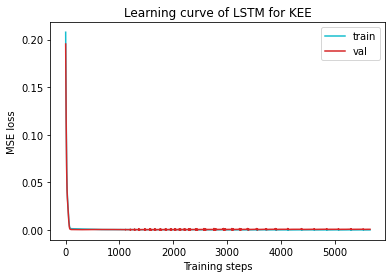

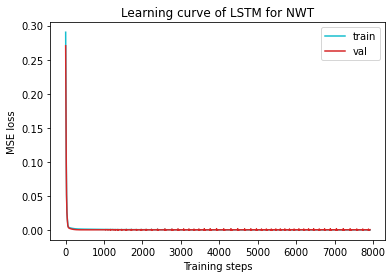

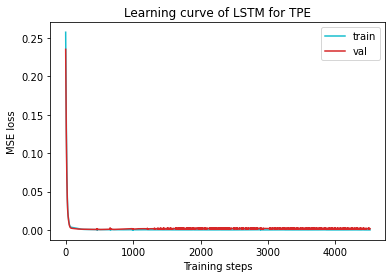

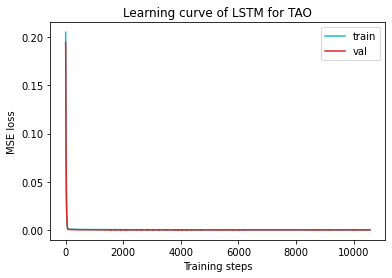

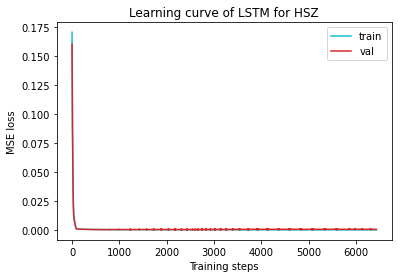

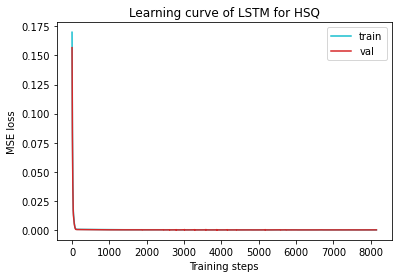

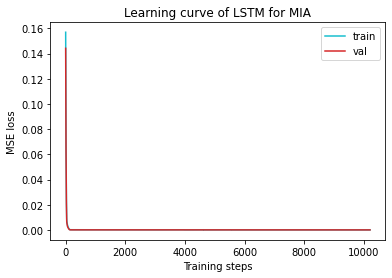

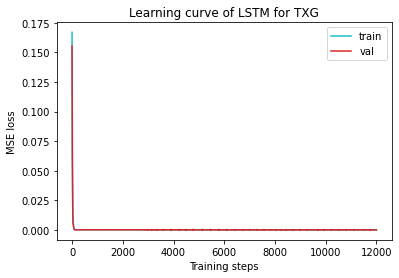

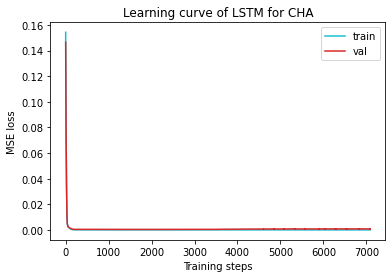

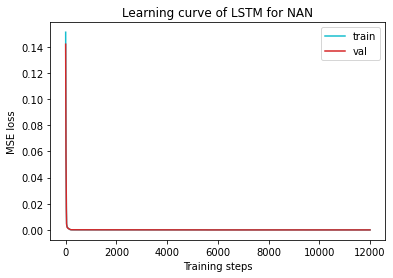

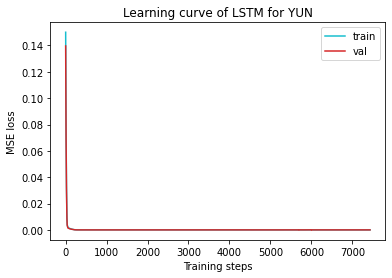

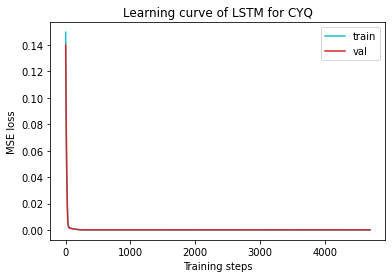

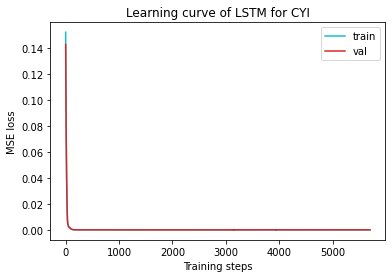

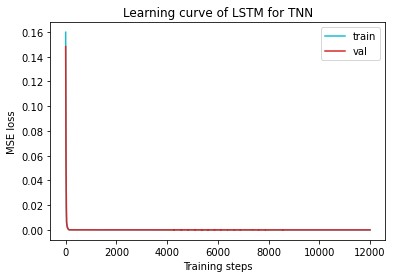

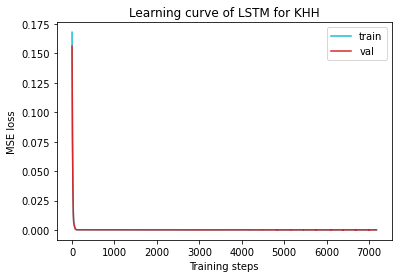

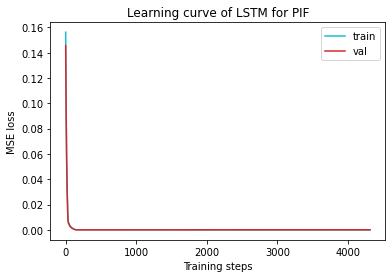

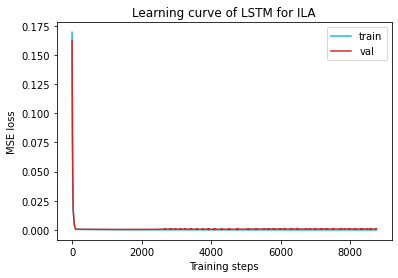

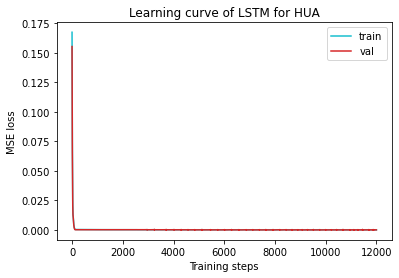

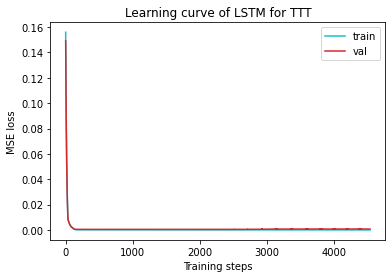

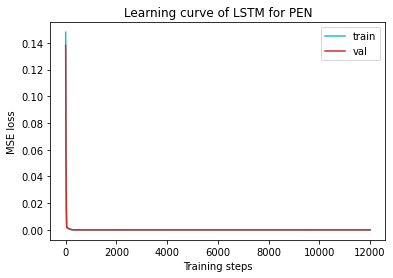

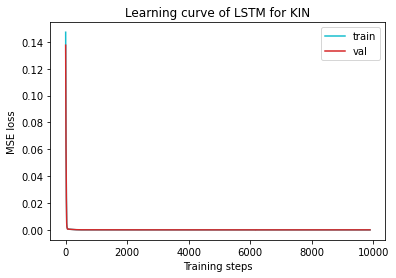

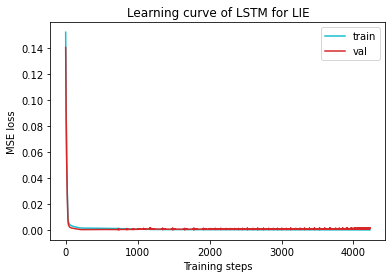

In [29]:
for city in city_codes:
    total_steps = len(loss_record[city]['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[city]['train']) // len(loss_record[city]['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[city]['train'], c='tab:cyan', label='train')
    plt.plot(x_2, loss_record[city]['val'], c='tab:red', label='val')
    plt.xlabel("Training steps")
    plt.ylabel("MSE loss")
    plt.title(f"Learning curve of LSTM for {city}")
    plt.legend()
    plt.show()

## **Testing**

Define plotting function.

In [34]:
def plot_predict(city, data_type, pred, real, start_date):
    plt.plot(pred)
    plt.plot(real)
    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted", "real"))

    if data_type == "Data":
        plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

Test for each city and plot it.

In [35]:
def test(city, model, X, Y):
    model.eval()
    _X, _Y = X.to(device), Y.to(device)
    test_predict = model(_X)
    loss = criterion(test_predict, _Y)

    return test_predict.detach().cpu(), loss.item()

tensor([0.0589, 0.0498, 0.0418])
tensor([0.0601, 0.0737, 0.0512, 0.0452, 0.0370])
[1676. 1416. 1190.]
real & predicted test loss: 0.03431768482550979


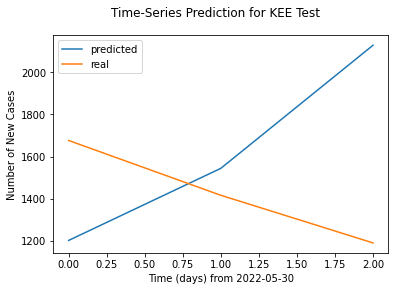

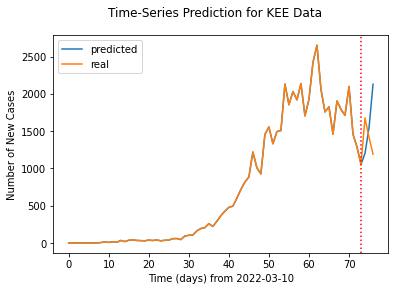

tensor([0.5366, 0.5346, 0.4535])
tensor([0.6568, 0.7306, 0.5990, 0.5553, 0.4001])
[15269.001 15211.    12904.   ]
real & predicted test loss: 0.07046331837773323


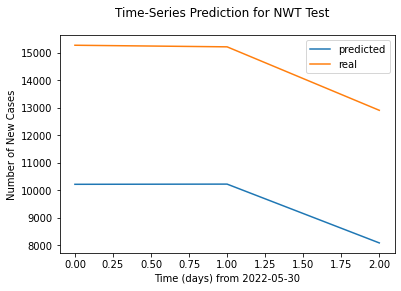

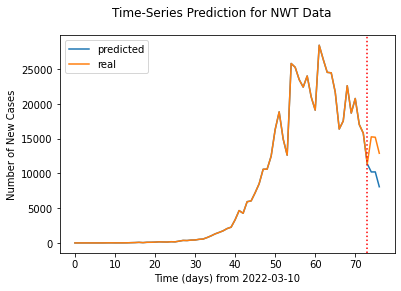

tensor([0.2046, 0.2541, 0.2192])
tensor([0.2829, 0.2864, 0.2493, 0.2251, 0.1732])
[5822. 7229. 6237.]
real & predicted test loss: 0.005326763028278947


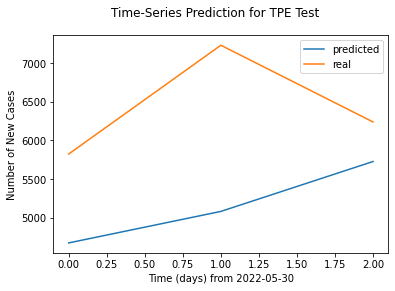

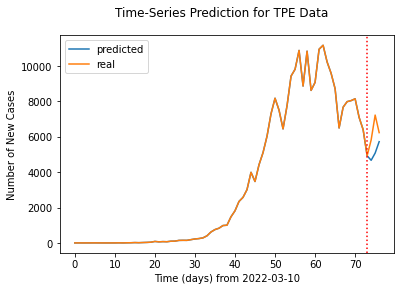

tensor([0.2856, 0.3430, 0.2760])
tensor([0.3435, 0.3653, 0.3260, 0.3398, 0.2345])
[8125.     9760.     7854.0005]
real & predicted test loss: 0.05510054109618068


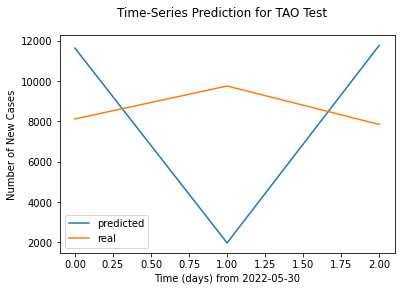

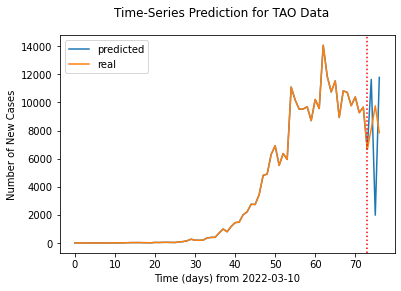

tensor([0.0641, 0.0730, 0.0557])
tensor([0.0610, 0.0788, 0.0639, 0.0616, 0.0411])
[1823.0001 2078.     1585.    ]
real & predicted test loss: 0.045821791514754295


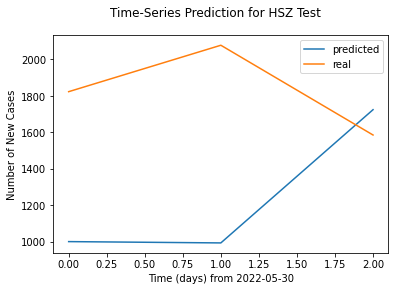

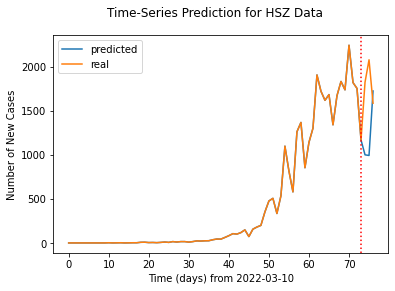

tensor([0.0720, 0.0881, 0.0802])
tensor([0.0812, 0.0970, 0.0891, 0.0702, 0.0676])
[2048. 2506. 2282.]
real & predicted test loss: 0.009060406940989196


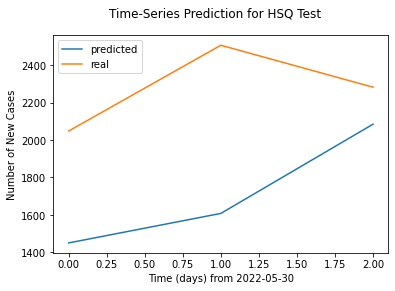

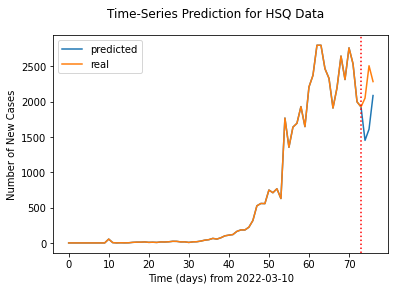

tensor([0.0658, 0.0682, 0.0574])
tensor([0.0591, 0.0769, 0.0698, 0.0590, 0.0568])
[1871. 1941. 1634.]
real & predicted test loss: 0.01057788886828348


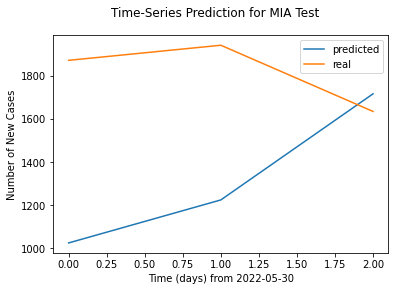

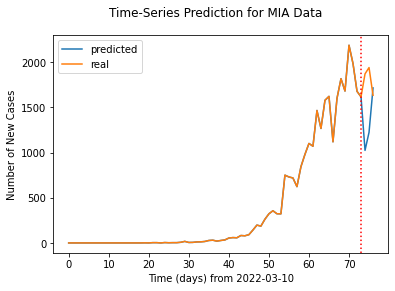

tensor([0.3750, 0.4080, 0.3763])
tensor([0.3499, 0.4021, 0.3160, 0.3138, 0.2664])
[10669. 11608. 10706.]
real & predicted test loss: 0.007895921356976032


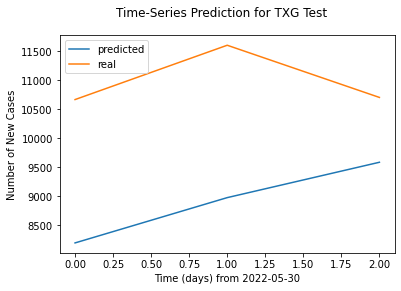

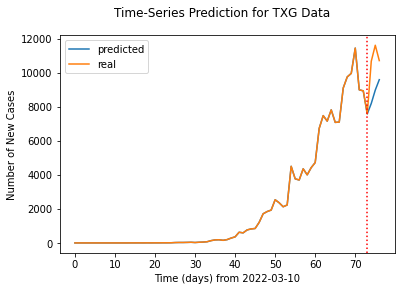

tensor([0.1593, 0.1633, 0.1596])
tensor([0.1107, 0.1418, 0.1211, 0.1320, 0.1077])
[4533. 4646. 4541.]
real & predicted test loss: 0.0064701728988438845


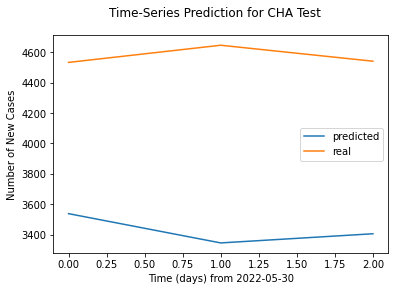

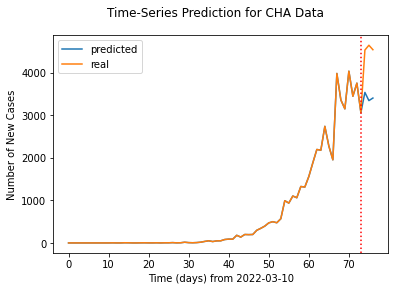

tensor([0.0478, 0.0512, 0.0464])
tensor([0.0349, 0.0449, 0.0335, 0.0337, 0.0308])
[1361. 1458. 1320.]
real & predicted test loss: 0.006784587632864714


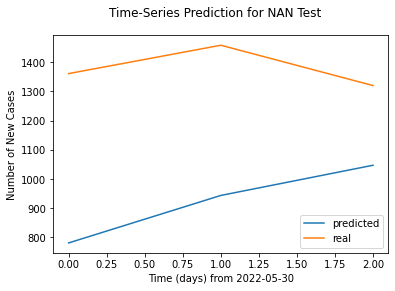

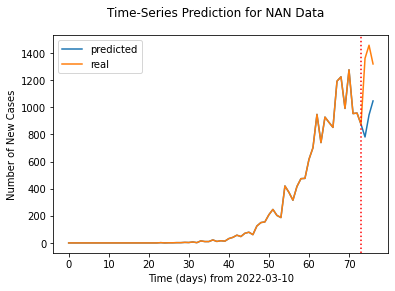

tensor([0.0540, 0.0638, 0.0496])
tensor([0.0376, 0.0573, 0.0497, 0.0367, 0.0395])
[1537.     1815.9999 1410.    ]
real & predicted test loss: 0.001114066006266512


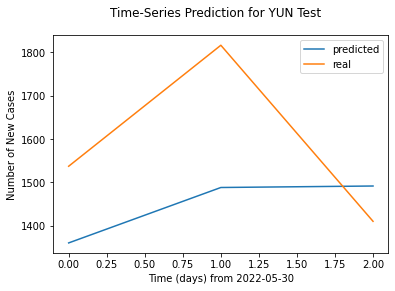

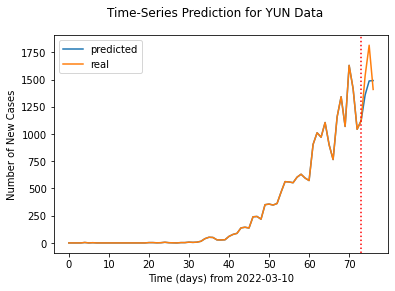

tensor([0.0383, 0.0422, 0.0411])
tensor([0.0316, 0.0353, 0.0340, 0.0333, 0.0254])
[1091. 1201. 1168.]
real & predicted test loss: 0.0028912161360494792


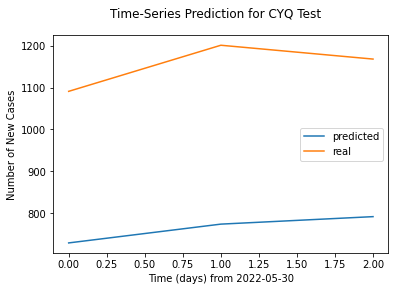

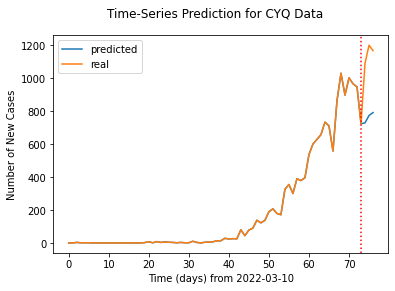

tensor([0.0277, 0.0239, 0.0266])
tensor([0.0183, 0.0227, 0.0198, 0.0183, 0.0154])
[789. 679. 756.]
real & predicted test loss: 0.007657636539079249


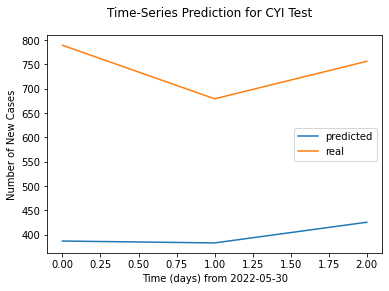

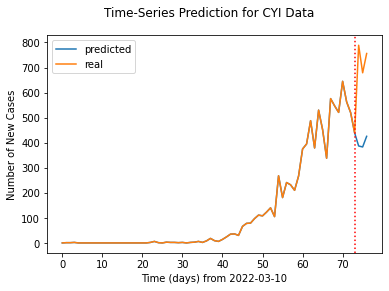

tensor([0.2250, 0.2710, 0.2159])
tensor([0.2023, 0.2535, 0.2307, 0.2018, 0.1476])
[6403. 7712. 6144.]
real & predicted test loss: 0.04106859676539898


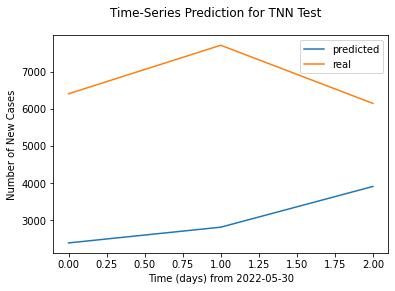

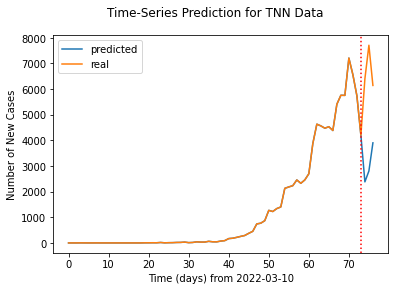

tensor([0.3807, 0.4122, 0.3700])
tensor([0.3096, 0.4090, 0.3523, 0.3485, 0.3028])
[10832. 11728. 10529.]
real & predicted test loss: 0.03813635744154453


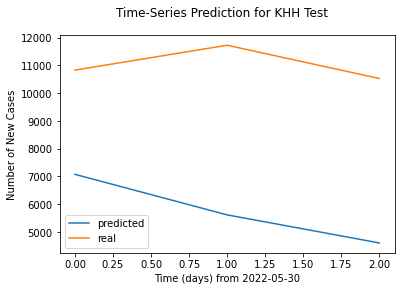

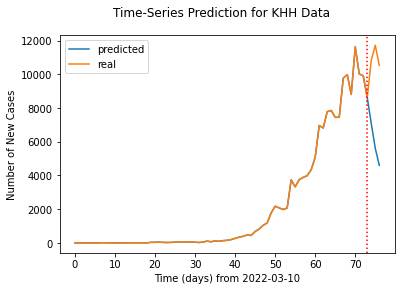

tensor([0.0947, 0.1038, 0.0975])
tensor([0.0856, 0.0887, 0.0841, 0.0819, 0.0687])
[2694. 2953. 2774.]
real & predicted test loss: 0.0040831988444551826


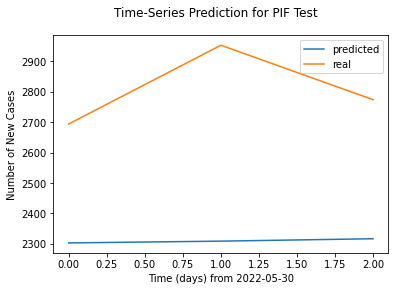

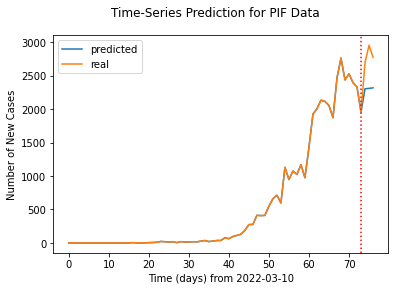

tensor([0.0589, 0.0572, 0.0501])
tensor([0.0712, 0.0591, 0.0657, 0.0552, 0.0355])
[1675. 1628. 1426.]
real & predicted test loss: 0.015161105897277594


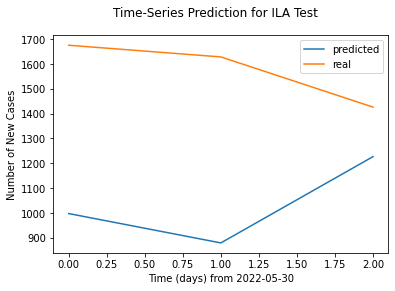

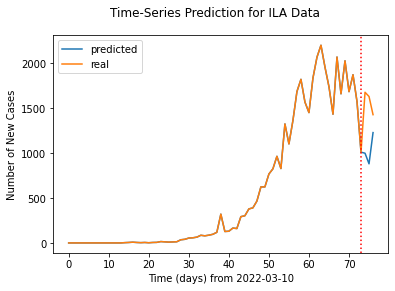

tensor([0.0444, 0.0515, 0.0428])
tensor([0.0456, 0.0487, 0.0459, 0.0395, 0.0329])
[1264. 1465. 1218.]
real & predicted test loss: 0.0032610069902148098


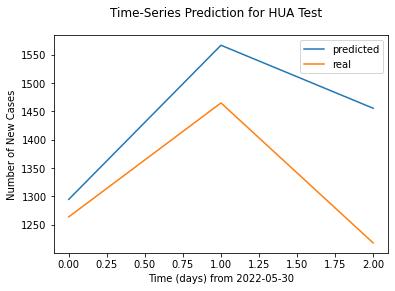

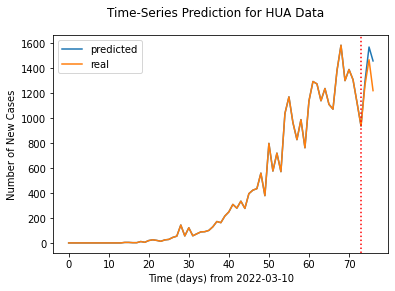

tensor([0.0277, 0.0310, 0.0309])
tensor([0.0238, 0.0283, 0.0252, 0.0283, 0.0197])
[788. 881. 879.]
real & predicted test loss: 0.00416200899053365


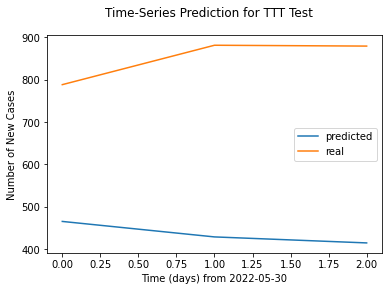

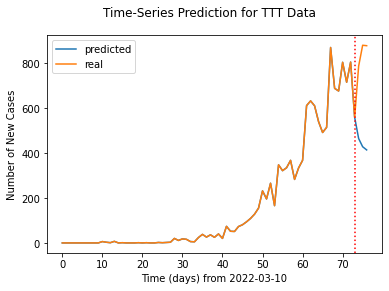

tensor([0.0068, 0.0054, 0.0076])
tensor([0.0051, 0.0044, 0.0045, 0.0046, 0.0031])
[193. 153. 216.]
real & predicted test loss: 0.005319457617588341


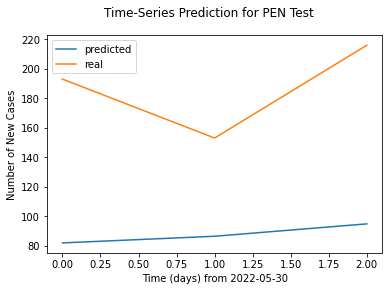

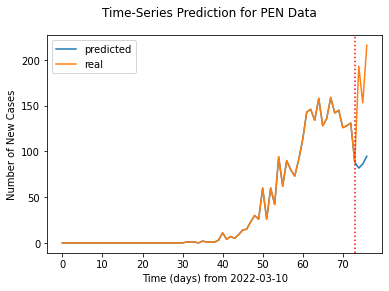

tensor([0.0046, 0.0035, 0.0051])
tensor([0.0044, 0.0027, 0.0050, 0.0039, 0.0029])
[131. 101. 145.]
real & predicted test loss: 0.00018147295850212686


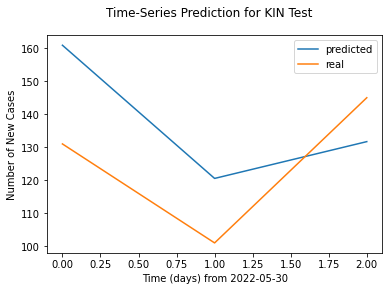

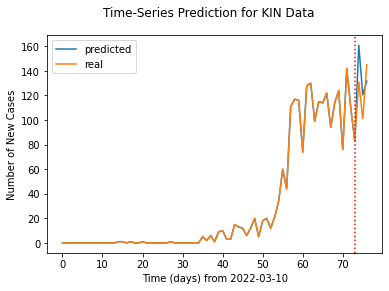

tensor([0.0003, 0.0018, 0.0009])
tensor([0.0006, 0.0009, 0.0033, 0.0011, 0.0007])
[ 9. 52. 25.]
real & predicted test loss: 0.02803432079963386


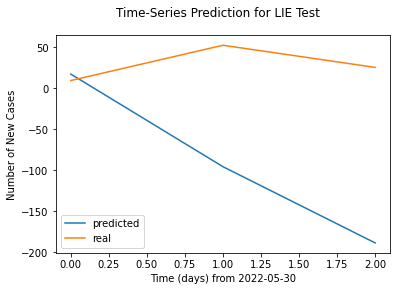

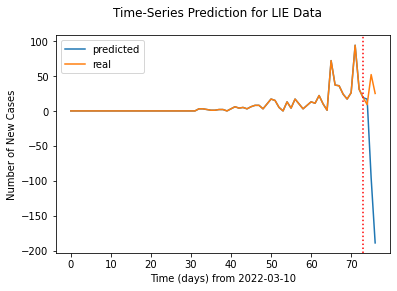

In [36]:
for city in city_codes:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)

    preprocData = cityWiseDataPreproc(cityWiseData, city, [])
    sc, dataX, dataY, _, trainY, _, _, testX, testY = data_preprocess(preprocData.values)
    
    # test set: real & predicted data -> predicted data
    _testX = testX[[0]].clone()
    total_loss = 0
    total_test_predict = []
    for i in range(testY.size(0)):
        test_predict, loss = test(city, lstm, _testX, testY[[i]])
        total_loss += loss
        total_test_predict.append(test_predict)
        # print(torch.unsqueeze(test_predict, 0).shape)

        # test_predict_arr = np.array([torch.squeeze(test_predict).item()]+[0]*(input_size-1))
        # print(test_predict_arr.shape)
        # print(test_predict_arr)
        # print(sc.inverse_transform(test_predict_arr[np.newaxis]))
        # test_predict_arr = sc.inverse_transform(test_predict_arr[np.newaxis])

        # print(minmaxNorm.inverse_transform(test_predict_arr))
        # test_predict_arr = minmaxNorm.inverse_transform(test_predict_arr)

        # print(_testX[:,1:].shape)
        _testX = torch.cat((_testX[:,1:], torch.unsqueeze(test_predict, 0)), 1)
    total_test_predict = torch.cat(total_test_predict)

    total_test_predict = minmaxNorm.inverse_transform(total_test_predict.data.numpy())
    print(testY[:, 0])
    print(trainY[-5:, 0])
    _testY = minmaxNorm.inverse_transform(testY.data.numpy())
    print(_testY[:5, 0])
    print(f"real & predicted test loss: {total_loss}")
    plot_predict(city, "Test", total_test_predict[:, 0], _testY[:, 0], test_start_date)

    dataY = minmaxNorm.inverse_transform(dataY.data.numpy())
    _dataY = np.copy(dataY)
    for i in range(testY.size(0)):
        _dataY[-test_size+i][0] = total_test_predict[i][0]
    plot_predict(city, "Data", _dataY[:, 0], dataY[:, 0], start_date)

    del lstm